## Import Libraries

In [186]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
import cv2 as cv
from PIL import Image
import imgaug.augmenters as iaa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
import keras_tuner as kt
from keras.models import load_model
import keras
import pydot
keras.utils.vis_utils.pydot = pydot
import keras_tuner

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D,Conv2D,Activation, Dropout, Flatten, Input, Dense
from tensorflow.keras.optimizers.legacy import Adam

import gradio as gr

In [35]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-02-24 14:15:16.313155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 14:15:16.314733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


1/ Load data
2/ Resize
3/ Equalize intensity
4/ Data augmentation

## Data Preprocessing

In [36]:
train_dir = os.path.join('Data2/', 'train')
validation_dir = os.path.join('Data2/', 'val')
test_dir = os.path.join('Data2/', 'test')

In [37]:
BATCH_SIZE = 32
IMG_SIZE = (299, 299)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            label_mode='categorical',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1714 files belonging to 12 classes.


In [38]:
len(train_dataset)

54

In [39]:
class_names = train_dataset.class_names

In [40]:
class_names

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle']

In [41]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 337 files belonging to 12 classes.


In [42]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           label_mode='categorical',
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 238 files belonging to 12 classes.


In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

2023-02-24 14:15:32.735151: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


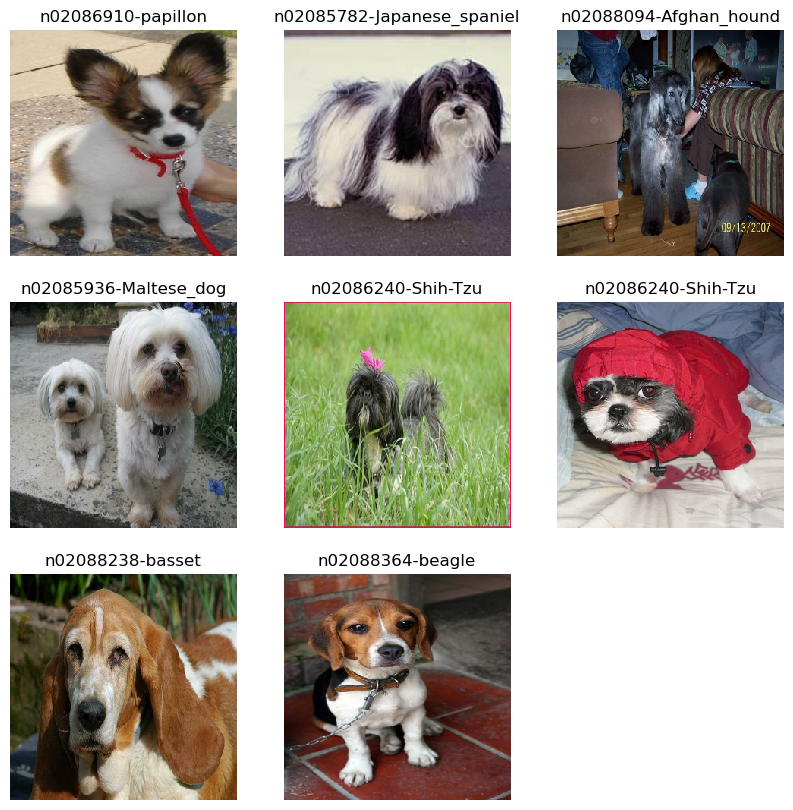

In [44]:
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):

    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'), interpolation='nearest')
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

## Data Augmentation

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define data augmentation settings
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [103]:
IMG_SIZE = 299

In [104]:
train_dataset_aug = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)

Found 1714 images belonging to 12 classes.


In [109]:
val_dataset_aug = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)

Found 337 images belonging to 12 classes.


In [177]:
test_dataset_aug = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    shuffle=False,
    class_mode='categorical',
    seed=42
   )

Found 238 images belonging to 12 classes.


In [73]:
x_train, y_train = train_dataset_aug[0]
x_val, y_val = val_dataset_aug[0]
print("Train input shape:", x_train.shape)
print("Train label shape:", y_train.shape)
print("Validation input shape:", x_val.shape)
print("Validation label shape:", y_val.shape)

TypeError: 'tuple' object cannot be interpreted as an integer

In [74]:
print(type(train_dataset_aug))
print(type(val_dataset_aug))

<class 'keras.preprocessing.image.DirectoryIterator'>
<class 'keras.preprocessing.image.DirectoryIterator'>


In [75]:
x_train, y_train = next(train_dataset_aug)
x_val, y_val = next(val_dataset_aug)

print("Train input shape:", x_train.shape)
print("Train label shape:", y_train.shape)
print("Validation input shape:", x_val.shape)
print("Validation label shape:", y_val.shape)

TypeError: 'tuple' object cannot be interpreted as an integer

### 2nd Data Augmentation startegy

In [63]:
train_generator = tf.data.Dataset.from_generator(lambda: train_dataset_aug,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 299, 299, 3], [None, 12]))

train_dataset_aug_2 = train_generator.prefetch(buffer_size=tf.data.AUTOTUNE)

### Visualizing some Data Augmentation technics

In [12]:
# Create preprocessing layers
resize = tf.keras.layers.Resizing(160, 160)
rescale = tf.keras.layers.Rescaling(1./255)
flip = tf.keras.layers.RandomFlip("horizontal")
rotate = tf.keras.layers.RandomRotation(0.2)
height = tf.keras.layers.RandomHeight(0.3)
width = tf.keras.layers.RandomWidth(0.3)
zoom = tf.keras.layers.RandomZoom(0.3)
crop = tf.keras.layers.RandomCrop(128, 256)

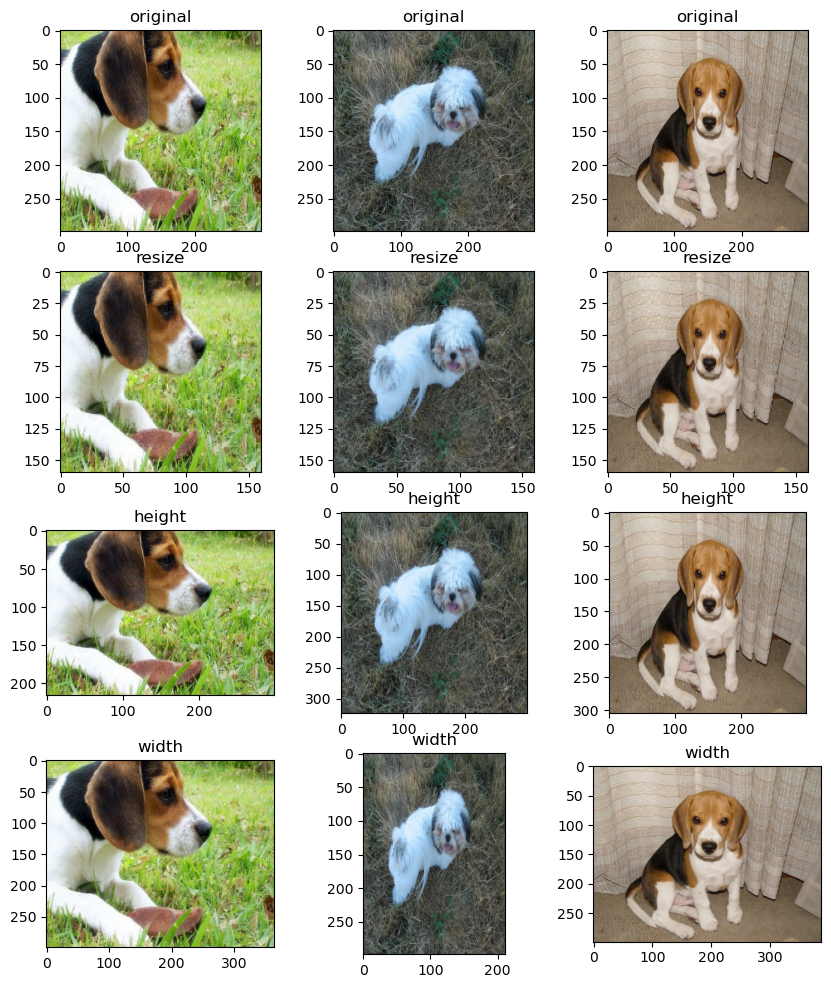

In [13]:
# Visualize images and augmentations
fig, ax = plt.subplots(4, 3, figsize=(10,12))

for images, labels in train_dataset.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # resize
        ax[1][i].imshow(resize(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("resize")
        # height
        ax[2][i].imshow(height(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("height")
        # width
        ax[3][i].imshow(width(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("width")
plt.show()

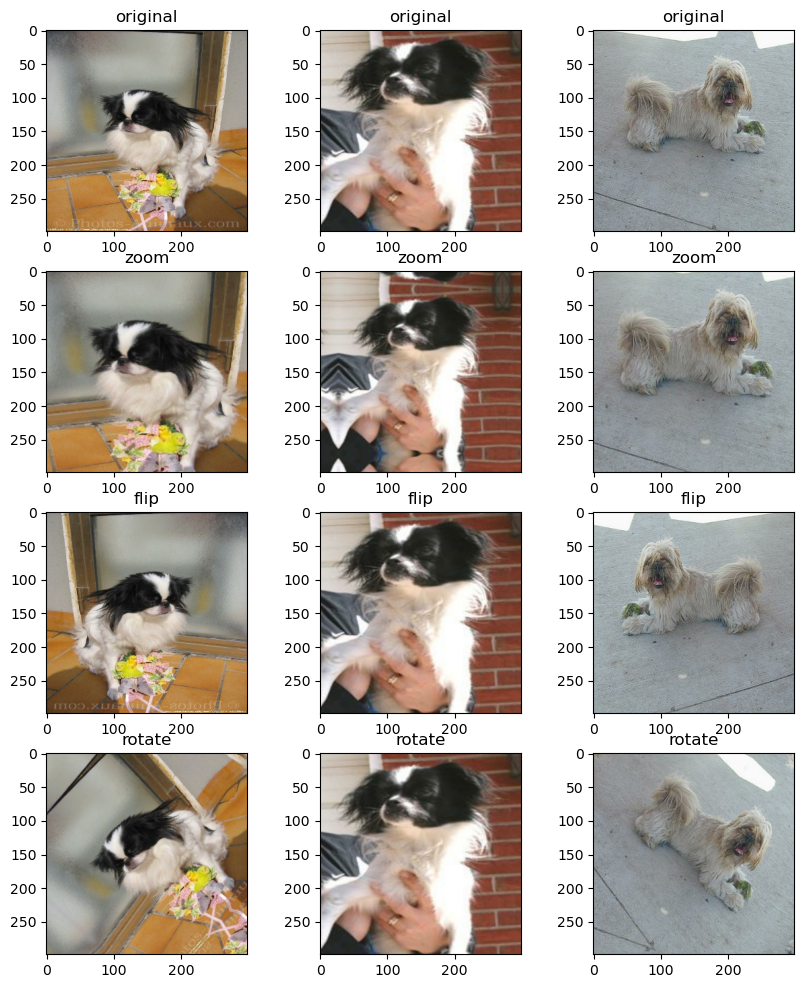

In [14]:
# Visualize images and augmentations
fig, ax = plt.subplots(4, 3, figsize=(10,12))

for images, labels in train_dataset.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # zoom
        ax[1][i].imshow(zoom(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("zoom")
        # flip
        ax[2][i].imshow(flip(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("flip")
        #rotate
        ax[3][i].imshow(rotate(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("rotate")
plt.show()

## Common function

In [20]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def plot_history_scores(dict_history, first_score, second_score, third_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,20))
        # summarize history for accuracy
        plt.subplot(2, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylim([0,1])
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(2, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(2, 2, 3)
        plt.plot(dict_history.history[third_score], color="g")
        plt.plot(dict_history.history['val_' + third_score],
                 linestyle='--', color="blue")
        plt.title('CNN model ' + third_score, fontsize=18)
        plt.ylim([0,1])
        plt.ylabel(third_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

## CNN Model 1 - from scratch

In [15]:
model1 = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 148, 148, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                      

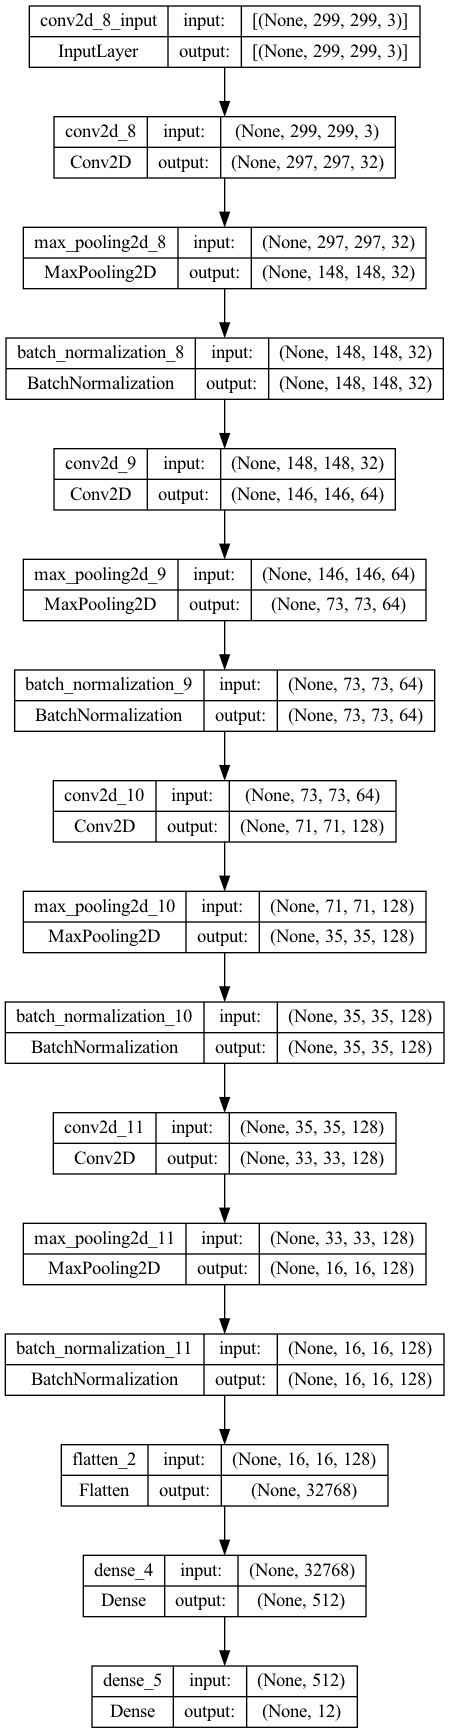

In [16]:
plot_model(model1, to_file='CNN_model1_plot.png',
           show_shapes=True, show_layer_names=True)

In [17]:
# Compile the CNN Model
from tensorflow.keras.optimizers.legacy import Adam

model1.compile(optimizer=Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy", f1_m])

In [18]:
model1.evaluate(validation_dataset)

2023-02-23 18:21:30.660247: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-23 18:21:30.661506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 10s 428ms/step - loss: 27.8346 - accuracy: 0.0801 - f1_m: 0.0842


[27.834577560424805, 0.08011869341135025, 0.08422455936670303]

In [19]:
from sklearn.utils import class_weight
checkpointer1 = ModelCheckpoint(filepath='models/CNN_model1_trial2.hdf5', verbose=1, save_best_only=True)

In [20]:
history = model1.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    callbacks = [checkpointer1])

Epoch 1/20


2023-02-23 18:23:56.902559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 13.0234 - accuracy: 0.1709 - f1_m: 0.1659
Epoch 1: val_loss improved from inf to 33.88968, saving model to models/CNN_model1_trial2.hdf5
54/54 [==============================] - 81s 1s/step - loss: 13.0234 - accuracy: 0.1709 - f1_m: 0.1659 - val_loss: 33.8897 - val_accuracy: 0.1068 - val_f1_m: 0.1030
Epoch 2/20
54/54 [==============================] - ETA: 0s - loss: 5.6227 - accuracy: 0.3407 - f1_m: 0.3222
Epoch 2: val_loss improved from 33.88968 to 13.36234, saving model to models/CNN_model1_trial2.hdf5
54/54 [==============================] - 72s 1s/step - loss: 5.6227 - accuracy: 0.3407 - f1_m: 0.3222 - val_loss: 13.3623 - val_accuracy: 0.1365 - val_f1_m: 0.1286
Epoch 3/20
54/54 [==============================] - ETA: 0s - loss: 1.9718 - accuracy: 0.5863 - f1_m: 0.5673
Epoch 3: val_loss improved from 13.36234 to 6.44951, saving model to models/CNN_model1_trial2.hdf5
54/54 [==============================] - 67s 1s/step - loss:

## CNN Model 1 evaluation and visualization

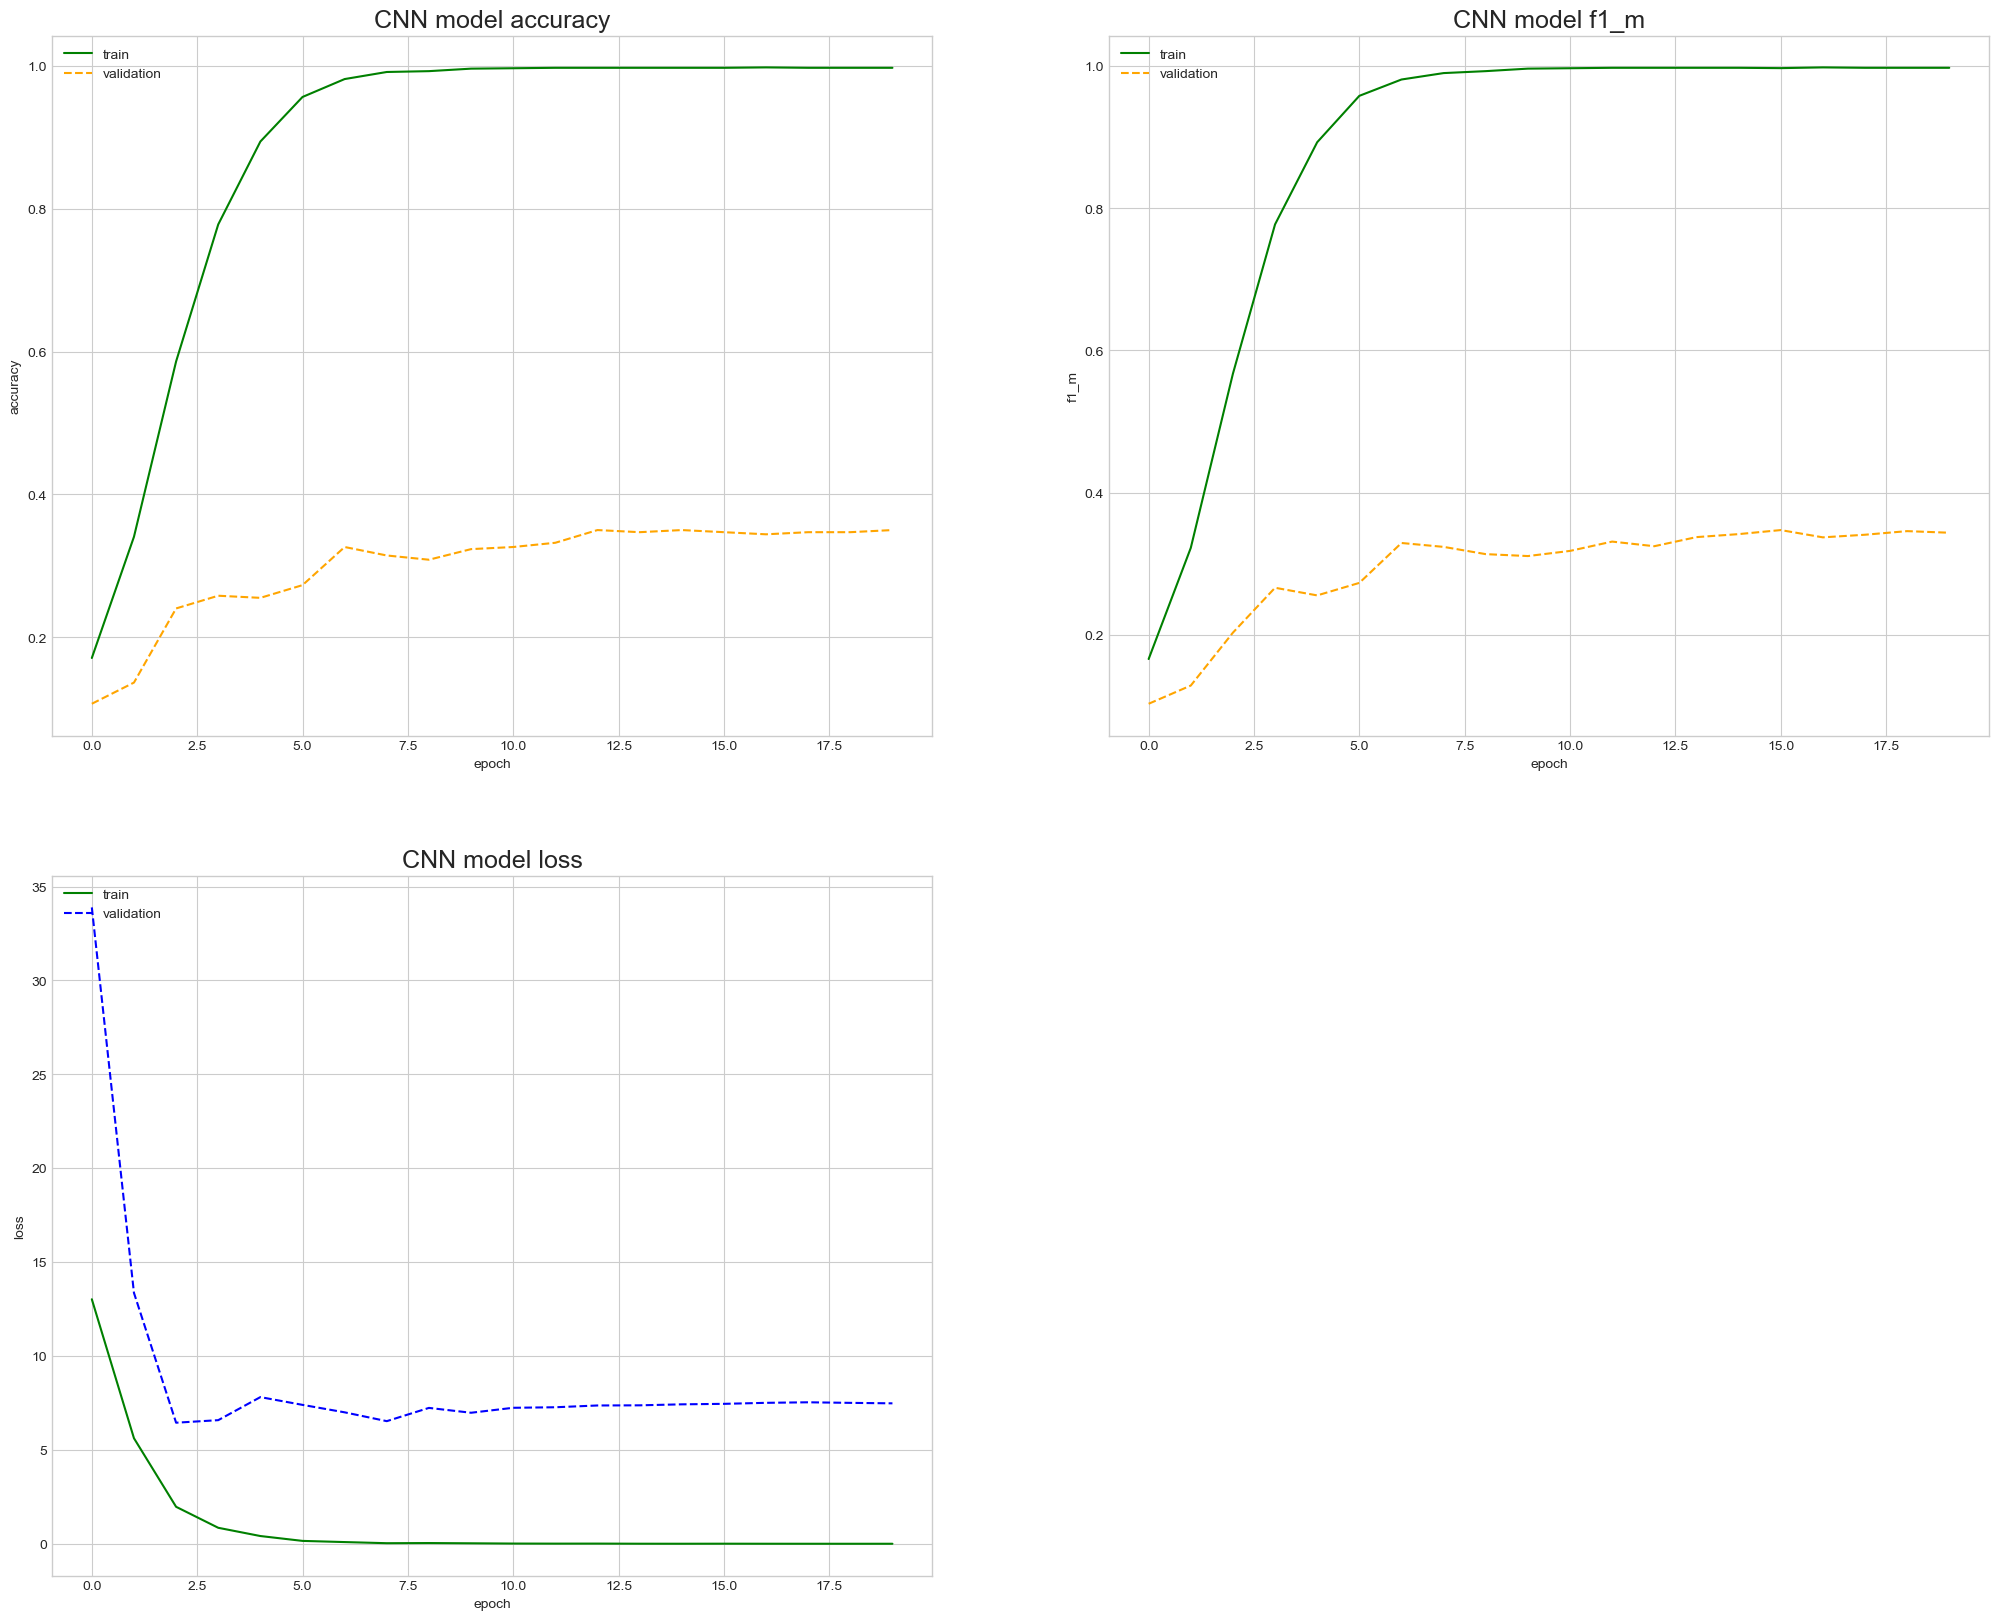

In [22]:
plot_history_scores(
    dict_history = history,
    first_score = "accuracy",
    second_score = "f1_m",
    third_score= "loss"
)

In [ ]:
# evaluer dans un context de production - donnee que ton model va avoir en prod
# monitoring - s'assurer que on rejette - on definit un set de metrics avec des seuils

## CNN Model 1 - adding data augmentation & reducing learning rate

In [91]:
model1_aug = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [92]:
model1_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 148, 148, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                      

In [93]:
# Compile the CNN Model
from tensorflow.keras.optimizers.legacy import Adam

model1_aug.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy", f1_m])

In [94]:
from sklearn.utils import class_weight
checkpointer1_aug = ModelCheckpoint(filepath='models/CNN_model1_aug_trial2.hdf5', verbose=1, save_best_only=True)

In [107]:
val_dataset_aug.image_shape

(299, 299, 3)

In [110]:
history_aug = model1_aug.fit(
    train_dataset_aug,
    epochs=10,
    validation_data= val_dataset_aug,
    callbacks = [checkpointer1_aug]
)

Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 1.6028 - accuracy: 0.5117 - f1_m: 0.4906
Epoch 1: val_loss did not improve from 2.96149
54/54 [==============================] - 63s 1s/step - loss: 1.6028 - accuracy: 0.5117 - f1_m: 0.4906 - val_loss: 8.2246 - val_accuracy: 0.1068 - val_f1_m: 0.1096
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 1.4235 - accuracy: 0.5566 - f1_m: 0.5368
Epoch 2: val_loss did not improve from 2.96149
54/54 [==============================] - 69s 1s/step - loss: 1.4235 - accuracy: 0.5566 - f1_m: 0.5368 - val_loss: 5.0031 - val_accuracy: 0.1424 - val_f1_m: 0.1386
Epoch 3/10
54/54 [==============================] - ETA: 0s - loss: 1.3188 - accuracy: 0.5951 - f1_m: 0.5739
Epoch 3: val_loss did not improve from 2.96149
54/54 [==============================] - 64s 1s/step - loss: 1.3188 - accuracy: 0.5951 - f1_m: 0.5739 - val_loss: 4.0109 - val_accuracy: 0.2047 - val_f1_m: 0.2008
Epoch 4/10
54/54 [=========================

In [114]:
history_aug2 = model1_aug.fit(
    train_dataset_aug,
    epochs=20,
    initial_epoch=10,
    validation_data= val_dataset_aug,
    callbacks = [checkpointer1_aug]
)

Epoch 11/20
54/54 [==============================] - ETA: 0s - loss: 0.7499 - accuracy: 0.7561 - f1_m: 0.7527
Epoch 11: val_loss did not improve from 2.82058
54/54 [==============================] - 67s 1s/step - loss: 0.7499 - accuracy: 0.7561 - f1_m: 0.7527 - val_loss: 3.0763 - val_accuracy: 0.3917 - val_f1_m: 0.3999
Epoch 12/20
54/54 [==============================] - ETA: 0s - loss: 0.7543 - accuracy: 0.7503 - f1_m: 0.7526
Epoch 12: val_loss did not improve from 2.82058
54/54 [==============================] - 101s 2s/step - loss: 0.7543 - accuracy: 0.7503 - f1_m: 0.7526 - val_loss: 3.4090 - val_accuracy: 0.3501 - val_f1_m: 0.3483
Epoch 13/20
54/54 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.7853 - f1_m: 0.7813
Epoch 13: val_loss did not improve from 2.82058
54/54 [==============================] - 97s 2s/step - loss: 0.6515 - accuracy: 0.7853 - f1_m: 0.7813 - val_loss: 3.0703 - val_accuracy: 0.3798 - val_f1_m: 0.3766
Epoch 14/20
54/54 [=================

## CNN Aug Model 1 evaluation and visualization

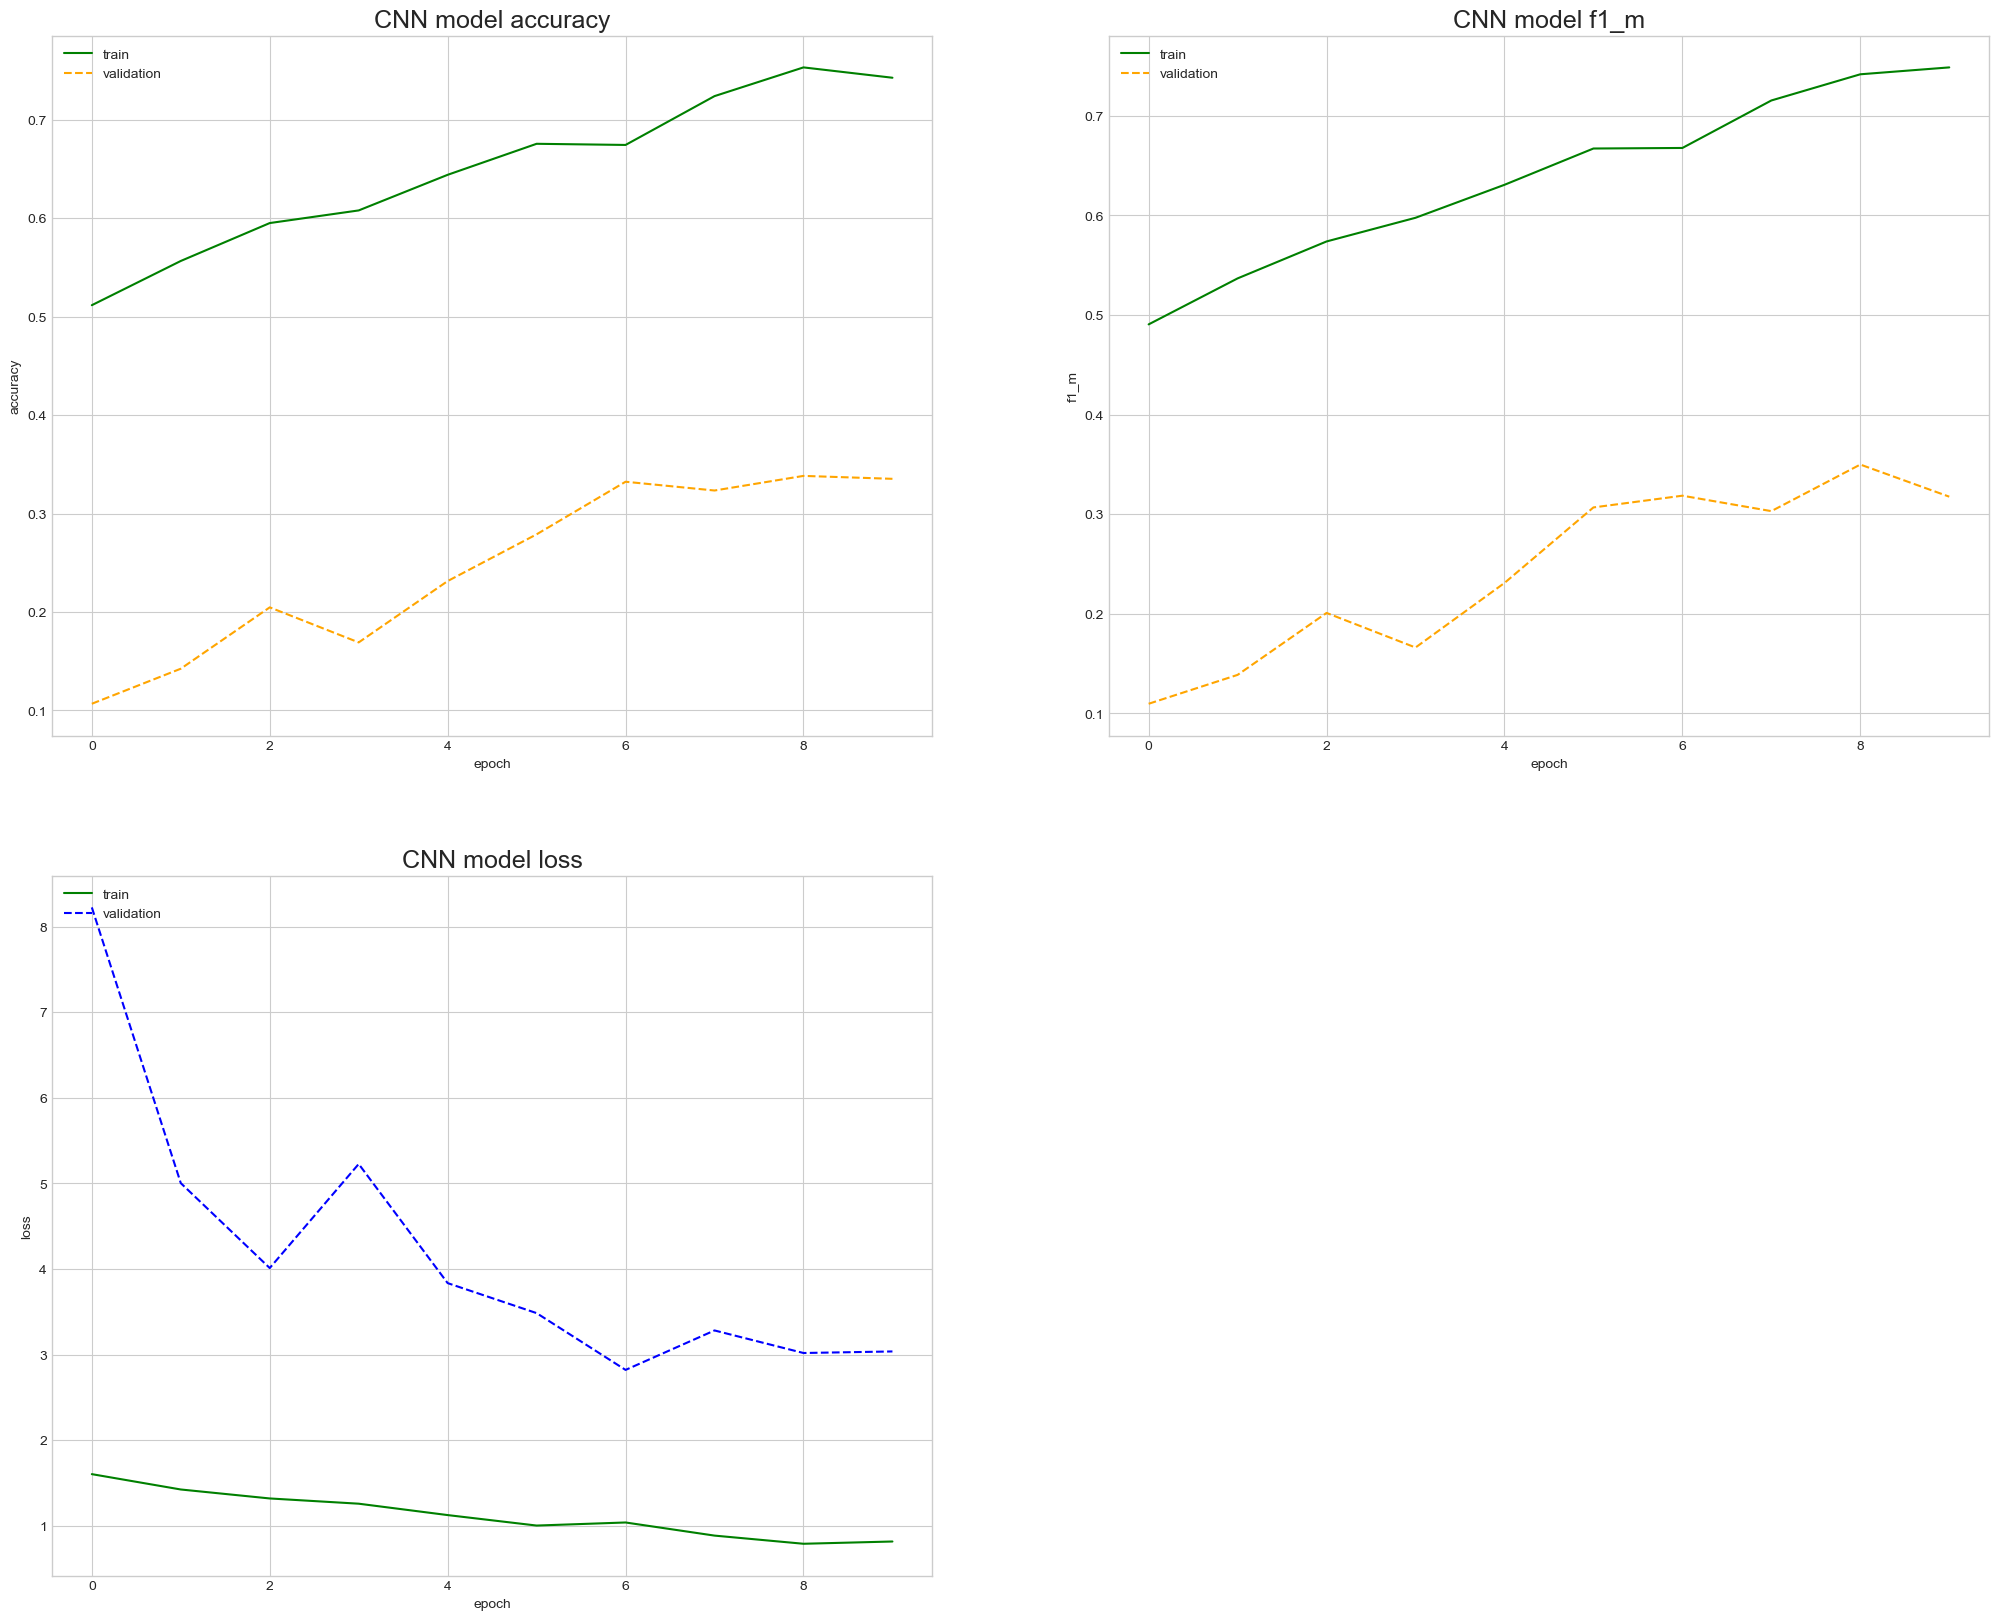

In [113]:
plot_history_scores(
    dict_history = history_aug,
    first_score = "accuracy",
    second_score = "f1_m",
    third_score= "loss"
)

In [115]:
acc_aug = history_aug.history['accuracy'] + history_aug2.history['accuracy']
val_acc_aug = history_aug.history['val_accuracy'] + history_aug2.history['val_accuracy']

loss_aug = history_aug.history['loss'] + history_aug2.history['loss']
val_loss_aug = history_aug.history['val_loss'] + history_aug2.history['val_loss']

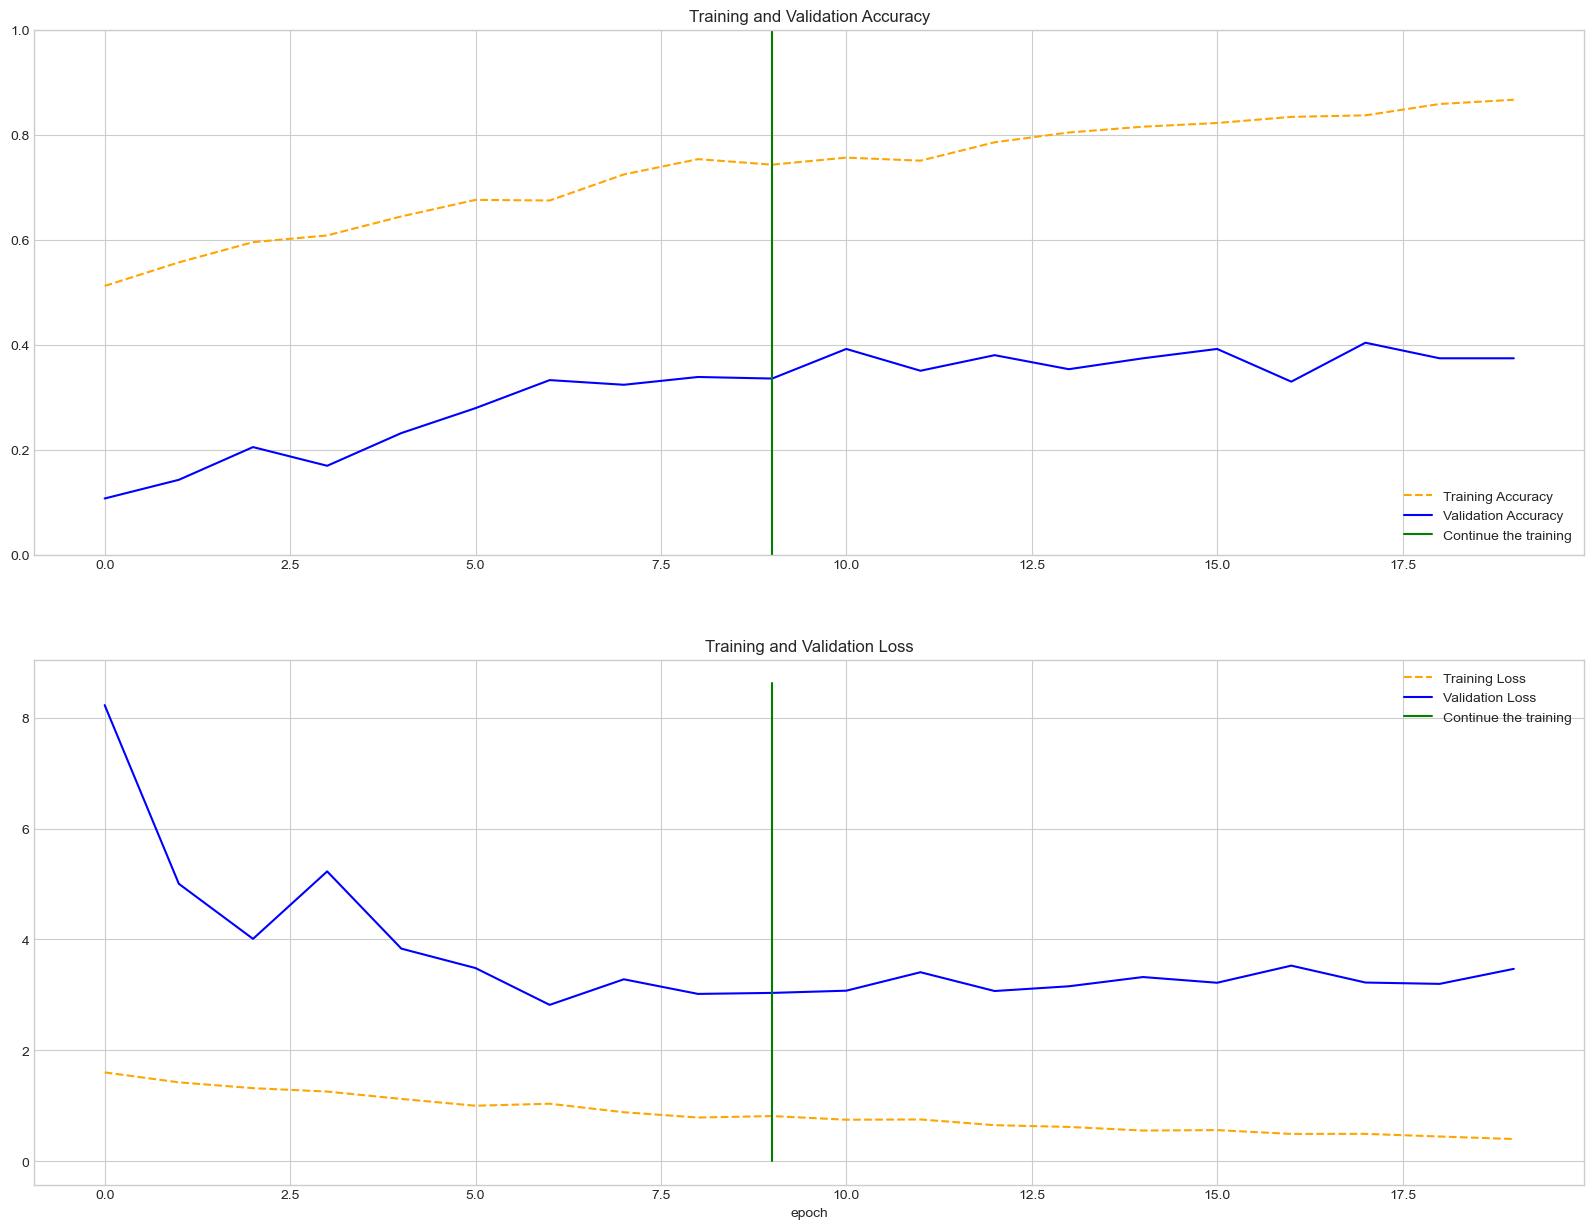

In [155]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(20, 15))
    plt.subplot(2, 1, 1)
    plt.plot(acc_aug, label='Training Accuracy', linestyle='--' ,color='orange')
    plt.plot(val_acc_aug, label='Validation Accuracy', color='b')
    plt.ylim([0, 1])
    plt.plot([10-1,10-1],
             plt.ylim(), label='Continue the training', color='g')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss_aug, label='Training Loss',linestyle='--' ,color='orange')
    plt.plot(val_loss_aug, label='Validation Loss', color='b')
    # plt.ylim([0, 1.0])
    plt.plot([10-1,10-1],
             plt.ylim(), label='Continue the training', color='g')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## CNN Model 2 - from scratch

In [131]:
K.clear_session()
model2 = Sequential([
    #1st conv layer
    Conv2D(filters=32,kernel_size=(5,5),padding='same',input_shape=(299,299,3),kernel_initializer='zeros',bias_initializer=tf.keras.initializers.Constant(0.1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'),
    BatchNormalization(axis=3,scale=True,gamma_initializer='glorot_normal',momentum=0.99),
    #2nd conv layer
    Conv2D(filters=46,kernel_size=(4,4),padding='same', use_bias=False),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'),
    BatchNormalization(axis=3, scale=False, momentum=0.88),
    #3rd conv layer
    Conv2D(filters=54,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'),
    BatchNormalization(axis=3,scale=True,gamma_initializer='glorot_normal',momentum=0.7),
    #4th conv layer
    Conv2D(filters=62,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'),
    BatchNormalization(axis=3,scale=True,gamma_initializer='glorot_normal',momentum=0.6),
    Dropout(0.1),
    #5th conv layer
    Conv2D(
        filters=64,kernel_size=(2,2),padding='same',use_bias=False, activation='relu'),
    BatchNormalization(axis=3, scale=False, momentum=0.9),
    GlobalAveragePooling2D(),
    # Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

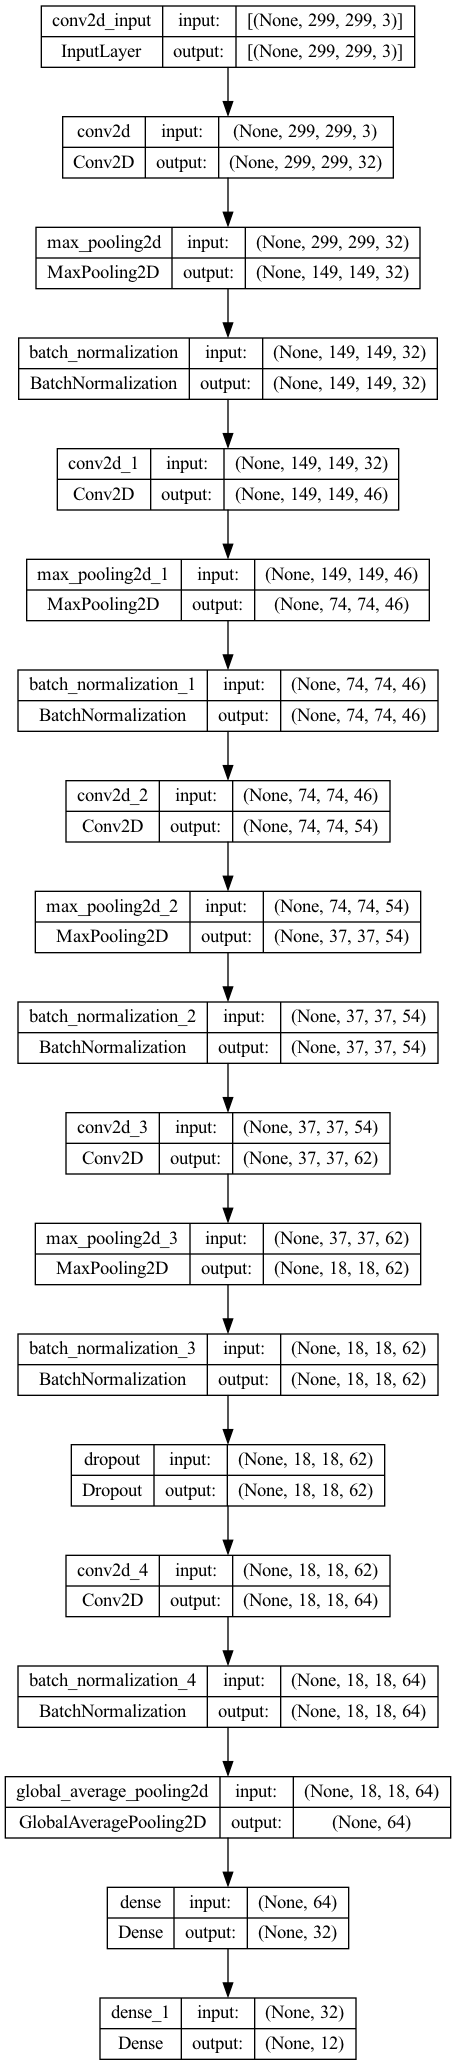

In [132]:
plot_model(model2, to_file='CNN_model2_plot.png',
           show_shapes=True, show_layer_names=True)

In [135]:
model2.compile(optimizer=Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy", f1_m])

In [136]:
checkpointer2 = ModelCheckpoint(filepath='models/CNN_model2_trial2.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

history2 = model2.fit(
    train_dataset_aug,
    epochs=10,
    validation_data= val_dataset_aug,
    callbacks = [checkpointer2]
)

Epoch 1/10


2023-02-24 16:42:05.277028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 2.4530 - accuracy: 0.1459 - f1_m: 0.0000e+00

2023-02-24 16:43:22.077483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 2.74347, saving model to models/CNN_model2_trial2.hdf5
54/54 [==============================] - 82s 1s/step - loss: 2.4530 - accuracy: 0.1459 - f1_m: 0.0000e+00 - val_loss: 2.7435 - val_accuracy: 0.1098 - val_f1_m: 0.0000e+00
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 2.4019 - accuracy: 0.1669 - f1_m: 0.0000e+00
Epoch 2: val_loss improved from 2.74347 to 2.62260, saving model to models/CNN_model2_trial2.hdf5
54/54 [==============================] - 68s 1s/step - loss: 2.4019 - accuracy: 0.1669 - f1_m: 0.0000e+00 - val_loss: 2.6226 - val_accuracy: 0.1098 - val_f1_m: 0.0000e+00
Epoch 3/10
54/54 [==============================] - ETA: 0s - loss: 2.3371 - accuracy: 0.1949 - f1_m: 0.0033
Epoch 3: val_loss did not improve from 2.62260
54/54 [==============================] - 91s 2s/step - loss: 2.3371 - accuracy: 0.1949 - f1_m: 0.0033 - val_loss: 2.7973 - val_accuracy: 0.1098 - val_f1_m: 0.0109
Epoch 4/10
54/54 [===============

In [138]:
history2_tbc = model2.fit(
    train_dataset_aug,
    epochs=20,
    initial_epoch=10,
    validation_data= val_dataset_aug,
    callbacks = [checkpointer2]
)

Epoch 11/20
54/54 [==============================] - ETA: 0s - loss: 1.9834 - accuracy: 0.3256 - f1_m: 0.1022
Epoch 11: val_loss improved from 2.27365 to 2.14006, saving model to models/CNN_model2_trial2.hdf5
54/54 [==============================] - 69s 1s/step - loss: 1.9834 - accuracy: 0.3256 - f1_m: 0.1022 - val_loss: 2.1401 - val_accuracy: 0.2938 - val_f1_m: 0.0520
Epoch 12/20
54/54 [==============================] - ETA: 0s - loss: 1.9315 - accuracy: 0.3401 - f1_m: 0.1174
Epoch 12: val_loss did not improve from 2.14006
54/54 [==============================] - 66s 1s/step - loss: 1.9315 - accuracy: 0.3401 - f1_m: 0.1174 - val_loss: 2.1950 - val_accuracy: 0.2760 - val_f1_m: 0.1152
Epoch 13/20
54/54 [==============================] - ETA: 0s - loss: 1.9085 - accuracy: 0.3466 - f1_m: 0.1426
Epoch 13: val_loss did not improve from 2.14006
54/54 [==============================] - 61s 1s/step - loss: 1.9085 - accuracy: 0.3466 - f1_m: 0.1426 - val_loss: 2.6806 - val_accuracy: 0.1365 - val

In [142]:
history2_tbc_2 = model2.fit(
    train_dataset_aug,
    epochs=30,
    initial_epoch=20,
    validation_data= val_dataset_aug,
    callbacks = [checkpointer2]
)

Epoch 21/30
54/54 [==============================] - ETA: 0s - loss: 1.6527 - accuracy: 0.4387 - f1_m: 0.2565
Epoch 21: val_loss did not improve from 1.95238
54/54 [==============================] - 69s 1s/step - loss: 1.6527 - accuracy: 0.4387 - f1_m: 0.2565 - val_loss: 2.3144 - val_accuracy: 0.2700 - val_f1_m: 0.1612
Epoch 22/30
54/54 [==============================] - ETA: 0s - loss: 1.6467 - accuracy: 0.4516 - f1_m: 0.2564
Epoch 22: val_loss improved from 1.95238 to 1.90788, saving model to models/CNN_model2_trial2.hdf5
54/54 [==============================] - 71s 1s/step - loss: 1.6467 - accuracy: 0.4516 - f1_m: 0.2564 - val_loss: 1.9079 - val_accuracy: 0.3531 - val_f1_m: 0.2746
Epoch 23/30
54/54 [==============================] - ETA: 0s - loss: 1.6200 - accuracy: 0.4539 - f1_m: 0.2786
Epoch 23: val_loss did not improve from 1.90788
54/54 [==============================] - 70s 1s/step - loss: 1.6200 - accuracy: 0.4539 - f1_m: 0.2786 - val_loss: 1.9853 - val_accuracy: 0.3175 - val

In [81]:
checkpointer2 = ModelCheckpoint(filepath='models/CNN_model2_trial2.hdf5', verbose=1, save_best_only=True)

history2 = model2.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2,
    callbacks=[checkpointer2])

Epoch 1/20


2023-02-18 18:08:51.407781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-18 18:09:42.799326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 2.48128, saving model to models/CNN_model2.hdf5
57/57 - 63s - loss: 2.4820 - accuracy: 0.1118 - f1_m: 10.0798 - val_loss: 2.4813 - val_accuracy: 0.1148 - val_f1_m: 13.3097 - 63s/epoch - 1s/step
Epoch 2/20

Epoch 2: val_loss improved from 2.48128 to 2.46964, saving model to models/CNN_model2.hdf5
57/57 - 54s - loss: 2.4458 - accuracy: 0.1401 - f1_m: 10.6750 - val_loss: 2.4696 - val_accuracy: 0.1148 - val_f1_m: 13.3436 - 54s/epoch - 939ms/step
Epoch 3/20

Epoch 3: val_loss did not improve from 2.46964
57/57 - 50s - loss: 2.3836 - accuracy: 0.1670 - f1_m: 10.2316 - val_loss: 2.4871 - val_accuracy: 0.1148 - val_f1_m: 12.7981 - 50s/epoch - 876ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 2.46964
57/57 - 48s - loss: 2.3862 - accuracy: 0.1759 - f1_m: 9.4924 - val_loss: 2.4792 - val_accuracy: 0.1120 - val_f1_m: 13.0575 - 48s/epoch - 837ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 2.46964
57/57 - 49s - loss: 2.3147 - accuracy: 0

## CNN Model 2 - evaluation and visualization

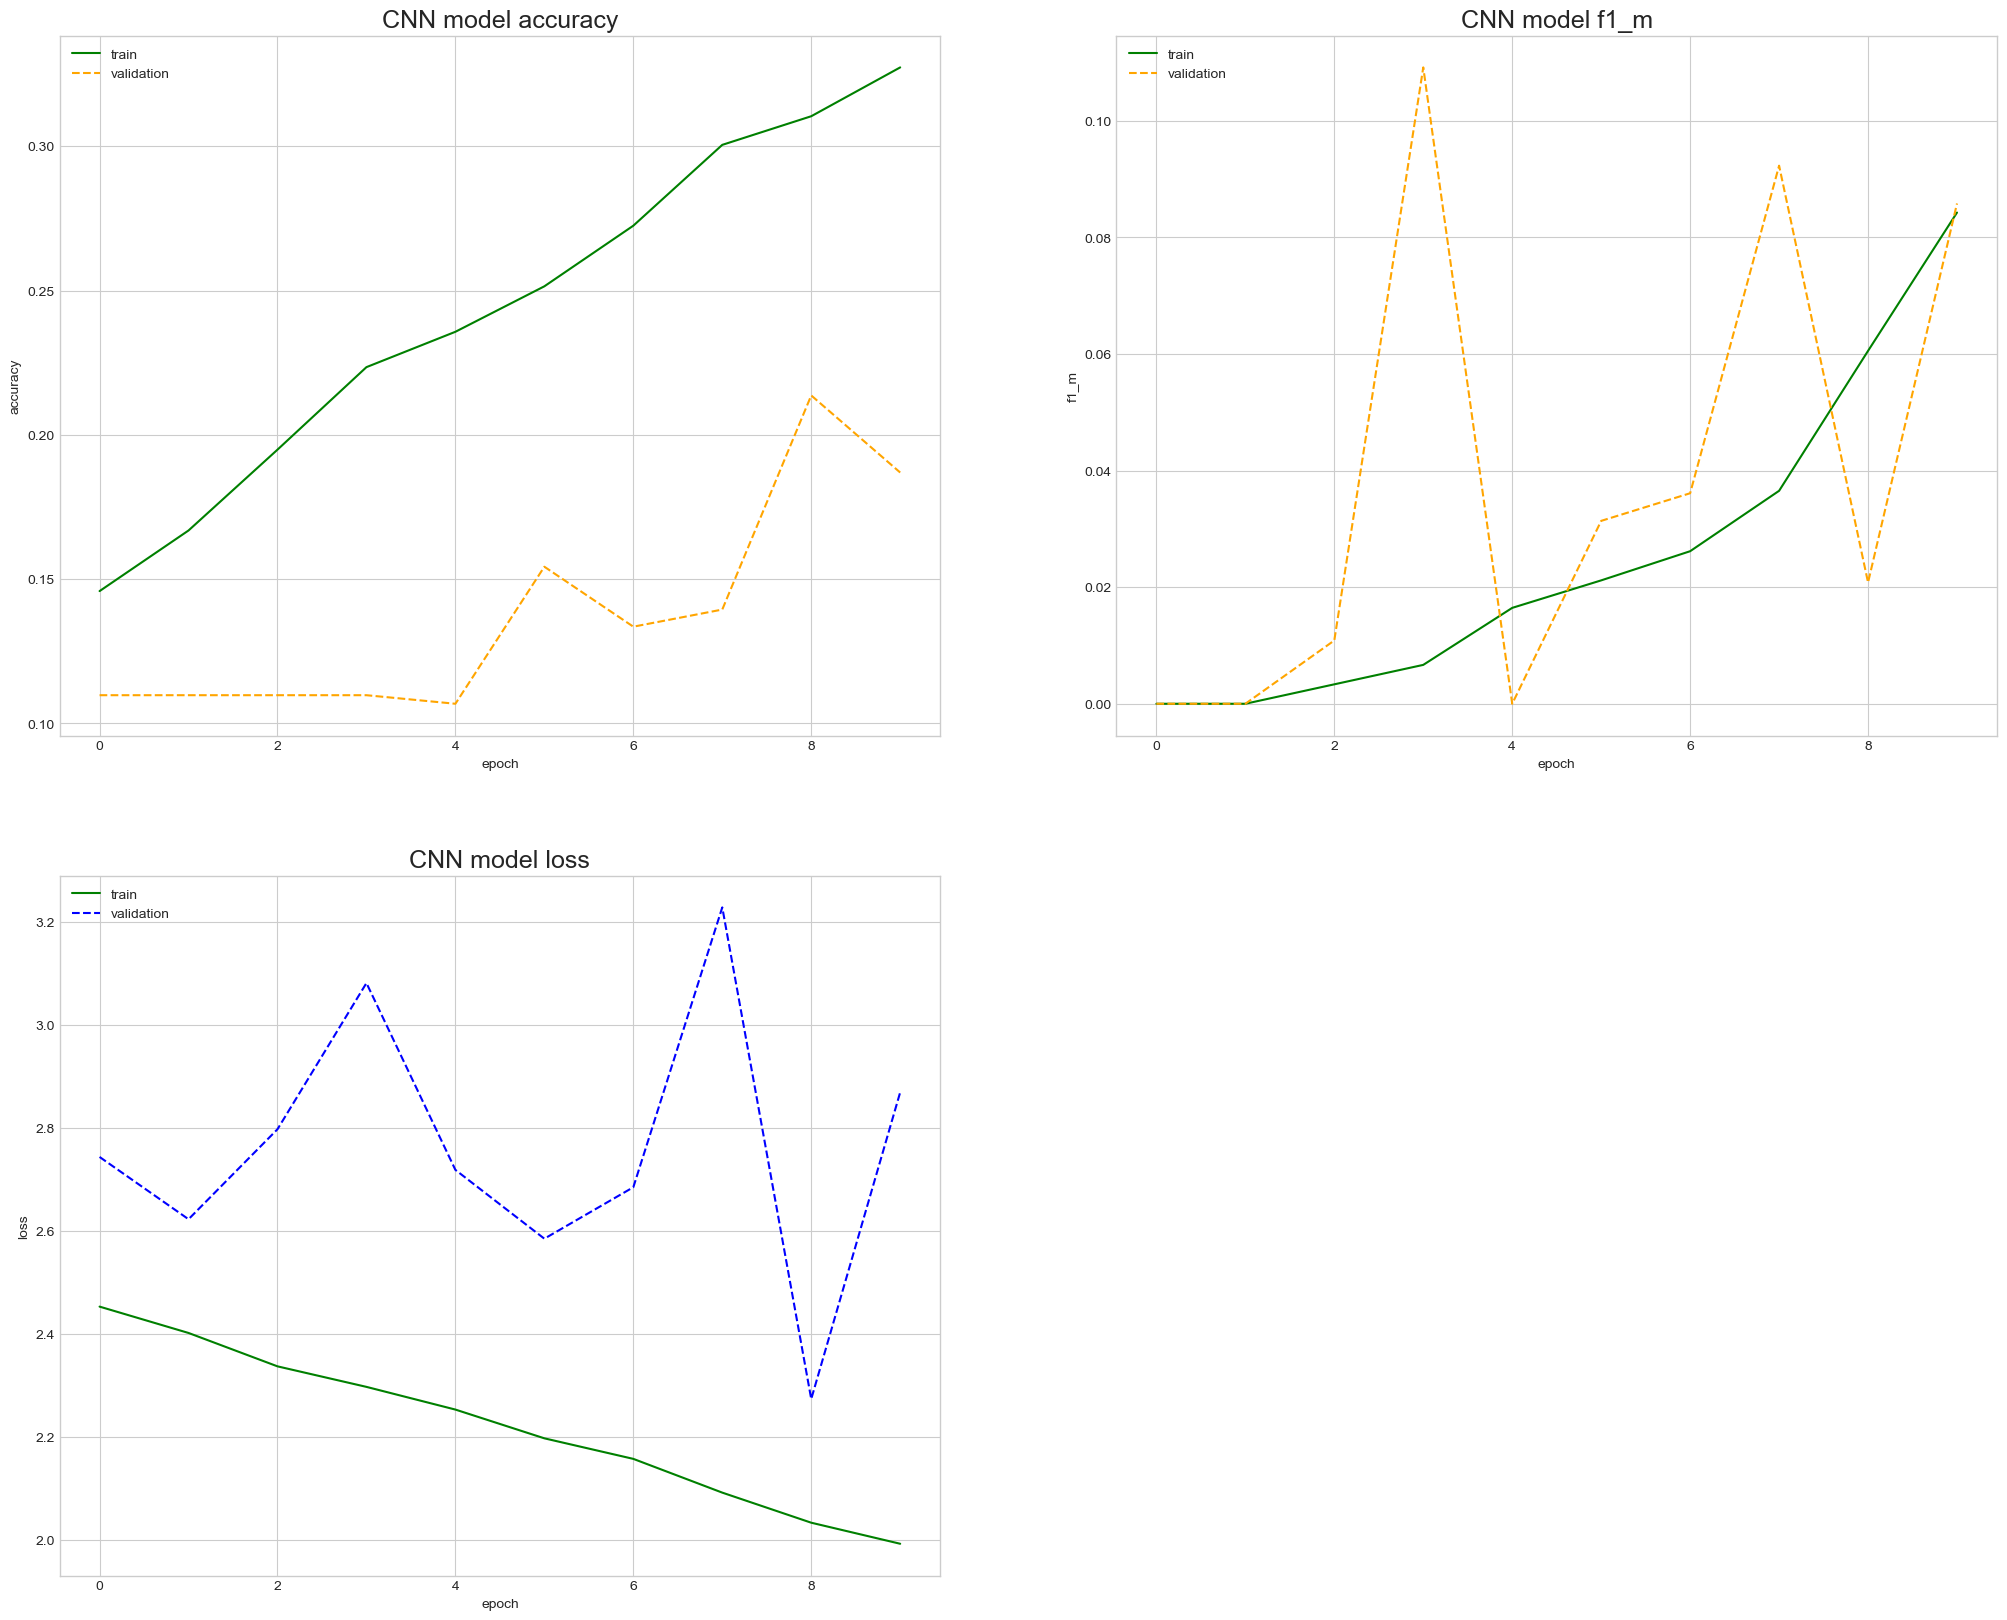

In [137]:
plot_history_scores(
    dict_history = history2,
    first_score = "accuracy",
    second_score = "f1_m",
    third_score= "loss"
)

In [139]:
acc2 = history2.history['accuracy'] + history2_tbc.history['accuracy']
val_acc2 = history2.history['val_accuracy'] + history2_tbc.history['val_accuracy']

loss2 = history2.history['loss'] + history2_tbc.history['loss']
val_loss2 = history2.history['val_loss'] + history2_tbc.history['val_loss']

In [158]:
acc3 = history2.history['accuracy'] + history2_tbc.history['accuracy'] + history2_tbc_2.history['accuracy']
val_acc3 = history2.history['val_accuracy'] + history2_tbc.history['val_accuracy'] + history2_tbc_2.history['val_accuracy']

loss3 = history2.history['loss'] + history2_tbc.history['loss'] + history2_tbc_2.history['loss']
val_loss3 = history2.history['val_loss'] + history2_tbc.history['val_loss'] + history2_tbc_2.history['val_loss']

f1_m3 = history2.history['f1_m'] + history2_tbc.history['f1_m'] + history2_tbc_2.history['f1_m']
val_f1_m3 = history2.history['val_f1_m'] + history2_tbc.history['val_f1_m'] + history2_tbc_2.history['val_f1_m']

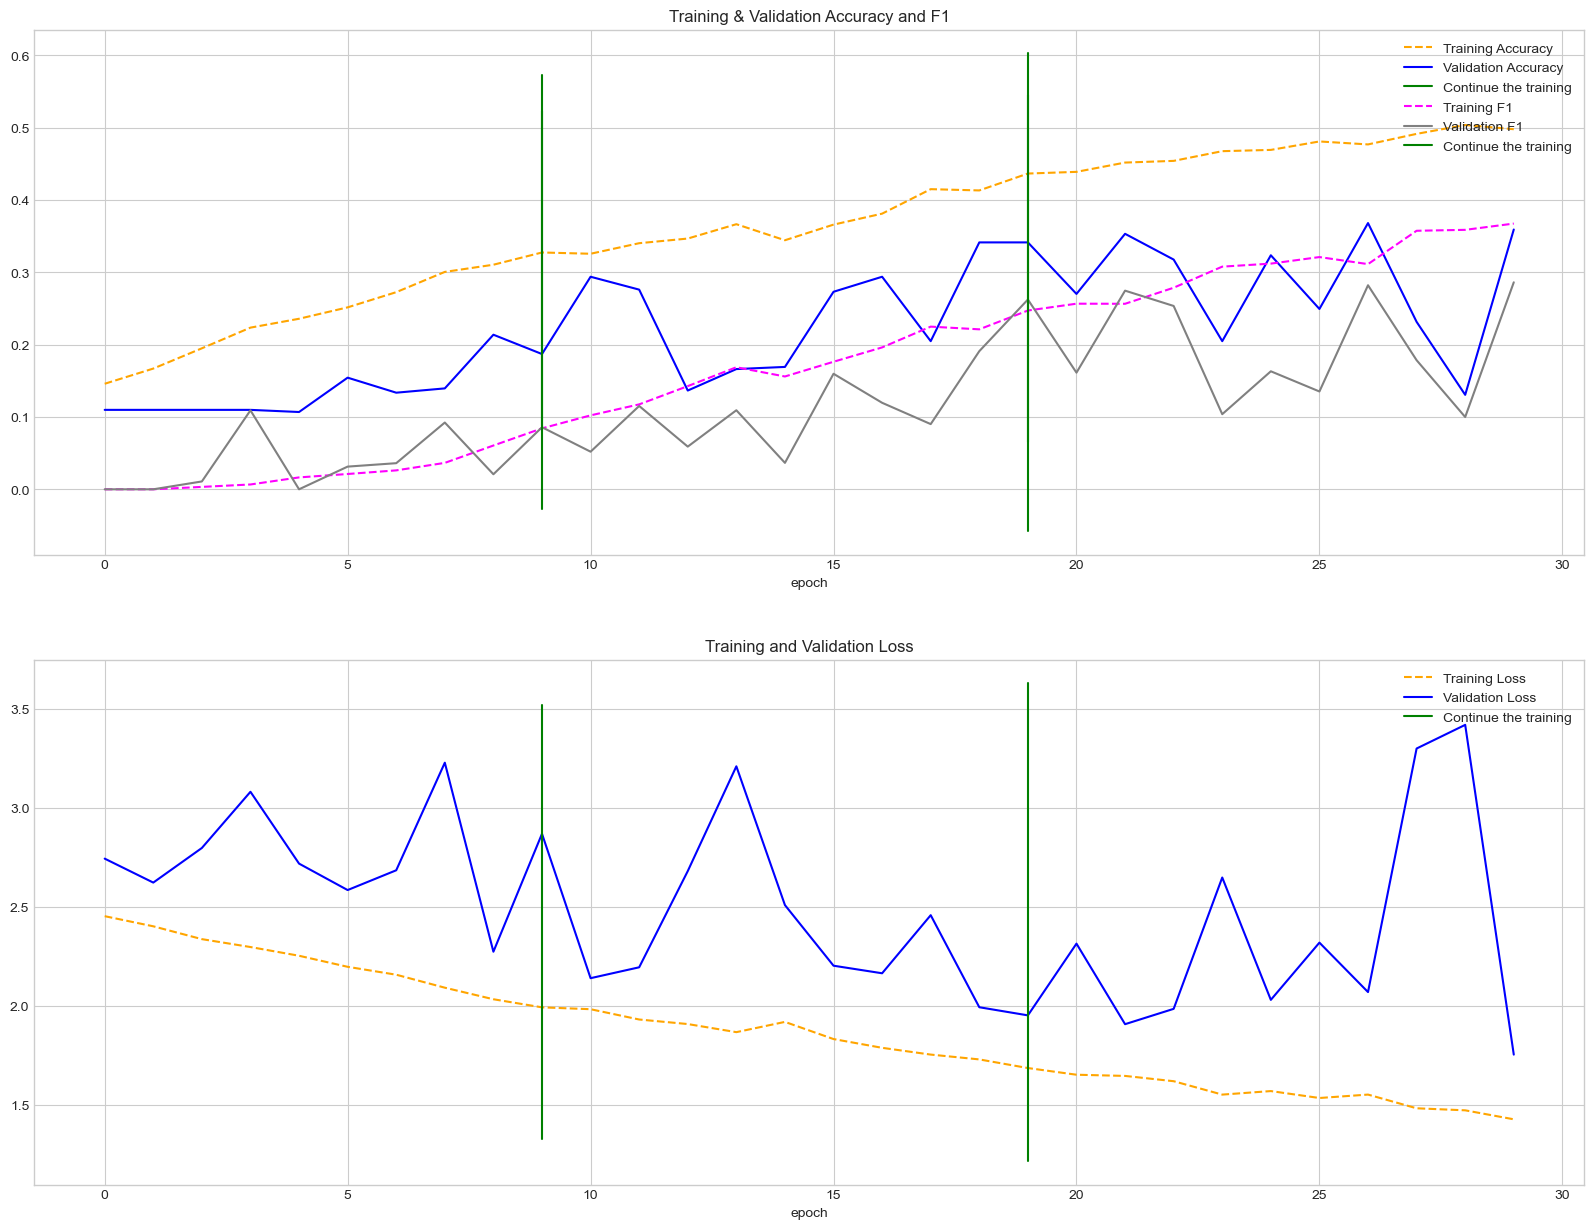

In [163]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(20,15))
    plt.subplot(2, 1, 1)
    plt.plot(acc3, label='Training Accuracy', color="orange", linestyle='--')
    plt.plot(val_acc3, label='Validation Accuracy', color="b")
    # plt.ylim([0, 1])
    plt.plot([10-1,10-1],
             plt.ylim(), label='Continue the training',color='g')
    plt.plot([20-1,20-1],
             plt.ylim(),color='g')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss3, label='Training Loss', color="orange", linestyle='--')
    plt.plot(val_loss3, label='Validation Loss', color="b")
    # plt.ylim([0, 1.0])
    plt.plot([10-1,10-1],
             plt.ylim(), label='Continue the training', color='g')
    plt.plot([20-1,20-1], plt.ylim(), color='g')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

    plt.subplot(2, 1, 1)
    plt.plot(f1_m3, label='Training F1', color="magenta", linestyle='--')
    plt.plot(val_f1_m3, label='Validation F1', color="grey")
    # plt.ylim([0, 1.0])
    plt.plot([10-1,10-1],
             plt.ylim(), label='Continue the training', color='g')
    plt.plot([20-1,20-1], plt.ylim(), color='g')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Accuracy and F1')
    plt.xlabel('epoch')
    plt.show()

## Load best Model

In [181]:
model2_loaded.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', f1_m])

In [182]:
model2_loaded.load_weights('models/CNN_model2_trial2.hdf5')

In [184]:
loss, acc, f1 = model2_loaded.evaluate(test_dataset_aug)

238/238 [==============================] - 5s 20ms/step - loss: 1.6980 - accuracy: 0.4160 - f1_m: 0.2017


## Tune the Model Architecture

In [201]:
def build_model(hp):
    model = Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization()
    ])
    model.add(Flatten())
    model.add(
        Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=350, max_value=700, step=35),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))
    model.add(Dense(12, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy", f1_m],
    )
    return model


build_model(keras_tuner.HyperParameters())

In [205]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="KerasTuner",
    project_name="Tune_1",
)

In [193]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 350, 'max_value': 700, 'step': 35, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [206]:
tuner.search(train_dataset_aug, epochs=5, validation_data=val_dataset_aug)

Trial 3 Complete [00h 04m 46s]
val_accuracy: 0.11127596348524094

Best val_accuracy So Far: 0.11869436129927635
Total elapsed time: 00h 13m 35s
INFO:tensorflow:Oracle triggered exit


In [203]:
tuner.search(train_dataset_aug, epochs=3, validation_data=val_dataset_aug)

Trial 3 Complete [00h 02m 30s]
val_accuracy: 0.115726999938488

Best val_accuracy So Far: 0.12314539775252342
Total elapsed time: 00h 07m 49s
INFO:tensorflow:Oracle triggered exit


In [195]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                        

In [196]:
tuner.results_summary()

Results summary
Results in KerasTuner/Tune_1
Showing 10 best trials
Trial summary
Hyperparameters:
units: 490
activation: relu
dropout: False
lr: 0.0003367031646782763
Score: 0.11275964602828026
Trial summary
Hyperparameters:
units: 700
activation: tanh
dropout: True
lr: 0.005524740499064619
Score: 0.10979228466749191
Trial summary
Hyperparameters:
units: 525
activation: tanh
dropout: True
lr: 0.0004837955703707695
Score: 0.10979228466749191


In [204]:
tuner.results_summary()

Results summary
Results in KerasTuner/Tune_1
Showing 10 best trials
Trial summary
Hyperparameters:
units: 525
activation: tanh
dropout: False
lr: 0.005387318024861541
Score: 0.12314539775252342
Trial summary
Hyperparameters:
units: 630
activation: tanh
dropout: False
lr: 0.0070200528663472385
Score: 0.115726999938488
Trial summary
Hyperparameters:
units: 455
activation: relu
dropout: False
lr: 0.0004627506437326911
Score: 0.11424332484602928


In [207]:
tuner.results_summary()

Results summary
Results in KerasTuner/Tune_1
Showing 10 best trials
Trial summary
Hyperparameters:
units: 630
activation: tanh
dropout: False
lr: 0.00013840401805079755
Score: 0.11869436129927635
Trial summary
Hyperparameters:
units: 630
activation: relu
dropout: False
lr: 0.00044541114312056005
Score: 0.11721068248152733
Trial summary
Hyperparameters:
units: 595
activation: tanh
dropout: False
lr: 0.00019140142918669913
Score: 0.11127596348524094


## Annexe - code essais

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator()

train_generator = gen.flow_from_directory(
        '/Users/maurelco/Developer/Python/Projet6/Images_train',  # this is the target directory
        target_size=(299, 299),  # all images will be resized
        color_mode='rgb',
        classes=None,
        batch_size=16,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix='',
        class_mode='categorical')
# for image_batch,labels in train_generator:
#         print(image_batch,labels)

In [ ]:
classes = np.unique(y)
class_weights = class_weight.compute_class_weight('balanced', classes= classes, y=y)


In [60]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, verbose=2, callbacks=[checkpointer], steps_per_epoch= len(x_train)/16)

Epoch 1/20


2023-02-17 17:32:30.607057: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-17 17:32:35.735878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-17 17:34:31.020420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 2727.03369, saving model to models/CNN_model1.hdf5
228/228 - 132s - loss: 2.4823 - accuracy: 0.1054 - f1_m: 12.0145 - val_loss: 2727.0337 - val_accuracy: 0.1026 - val_f1_m: 0.9460 - 132s/epoch - 577ms/step
Epoch 2/20

Epoch 2: val_loss did not improve from 2727.03369
228/228 - 116s - loss: 2.4784 - accuracy: 0.1068 - f1_m: 12.0453 - val_loss: 229498.6562 - val_accuracy: 0.1026 - val_f1_m: 0.9437 - 116s/epoch - 507ms/step
Epoch 3/20

Epoch 3: val_loss did not improve from 2727.03369
228/228 - 107s - loss: 2.4761 - accuracy: 0.1100 - f1_m: 11.9829 - val_loss: 6947013.0000 - val_accuracy: 0.1026 - val_f1_m: 0.9437 - 107s/epoch - 469ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 2727.03369
228/228 - 109s - loss: 2.4749 - accuracy: 0.1100 - f1_m: 12.0252 - val_loss: 23020782.0000 - val_accuracy: 0.1026 - val_f1_m: 0.9437 - 109s/epoch - 477ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 2727.03369
228/228 - 105s - loss: 2.4741 - 

KeyboardInterrupt: 